# Triplet Loss

### Load Train, Test, and Validation data

In [1]:
import numpy as np

In [2]:
train_features_path =  "../feature/BENGALI-feature/train_features.npy"
train_names_path = "../feature/BENGALI-feature/train_names.npy"
train_labels_path = "../feature/BENGALI-feature/train_labels.npy"

test_features_path = "../feature/BENGALI-feature/test_features.npy"
test_names_path = "../feature/BENGALI-feature/test_names.npy"
test_labels_path = "../feature/BENGALI-feature/test_labels.npy"

validation_features_path = "../feature/BENGALI-feature/validation_features.npy"
validation_names_path = "../feature/BENGALI-feature/validation_names.npy"
validation_labels_path = "../feature/BENGALI-feature/validation_labels.npy"

gallery_feature_path = "../feature/BENGALI-feature/gallery_features.npy"
gallery_name_path = "../feature/BENGALI-feature/gallery_names.npy"

train_features = np.load(train_features_path)
train_names = np.load(train_names_path)
train_labels = np.load(train_labels_path)

test_features = np.load(test_features_path)
test_names = np.load(test_names_path)
test_labels = np.load(test_labels_path)

validation_features = np.load(validation_features_path)
validation_names = np.load(validation_names_path)
validation_labels = np.load(validation_labels_path)

gallery_features = np.load(gallery_feature_path)
gallery_names = np.load(gallery_name_path)

In [3]:
print(train_features.shape)
print(train_labels.shape)
print(train_names.shape)
print(test_features.shape)
print(test_labels.shape)
print(test_names.shape)
print(validation_features.shape)
print(validation_labels.shape)
print(validation_names.shape)
print(gallery_features.shape)
print(gallery_names.shape)

(3200, 512)
(3200,)
(3200,)
(1100, 512)
(1100,)
(1100,)
(1100, 512)
(1100,)
(1100,)
(100, 512)
(100,)


### Creating Triplets

In [4]:
unique_names = set(train_names.flatten())
sorted_names = sorted(unique_names)

In [5]:
print(sorted_names)

['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '022', '023', '024', '025', '026', '027', '028', '029', '030', '031', '032', '033', '034', '035', '036', '037', '038', '039', '040', '041', '042', '043', '044', '045', '046', '047', '048', '049', '050', '051', '052', '053', '054', '055', '056', '057', '058', '059', '060', '061', '062', '063', '064', '065', '066', '067', '068', '069', '070', '071', '072', '073', '074', '075', '076', '077', '078', '079', '080', '081', '082', '083', '084', '085', '086', '087', '088', '089', '090', '091', '092', '093', '094', '095', '096', '097', '098', '099', '100']


In [6]:
print(gallery_names)

['001' '002' '003' '004' '005' '006' '007' '008' '009' '010' '011' '012'
 '013' '014' '015' '016' '017' '018' '019' '020' '021' '022' '023' '024'
 '025' '026' '027' '028' '029' '030' '031' '032' '033' '034' '035' '036'
 '037' '038' '039' '040' '041' '042' '043' '044' '045' '046' '047' '048'
 '049' '050' '051' '052' '053' '054' '055' '056' '057' '058' '059' '060'
 '061' '062' '063' '064' '065' '066' '067' '068' '069' '070' '071' '072'
 '073' '074' '075' '076' '077' '078' '079' '080' '081' '082' '083' '084'
 '085' '086' '087' '088' '089' '090' '091' '092' '093' '094' '095' '096'
 '097' '098' '099' '100']


In [7]:
def create_triplets(unique_names, gallery_features, features, labels):
    anchors, positives, negatives = [], [], []
    for name, gallery in zip(unique_names, gallery_features):
        # find all the instances for name
        indices = np.where(train_names == name)[0]
        # print(indices)
        
        # separate instances to positive and negative
        positive_set, negative_set = [], []
        for index in indices:
            # print(index)
            if labels[index] == 0:
                negative_set.append(features[index])
                # print(features[index])
            else:
                positive_set.append(features[index]) 

        negative_set = np.array(negative_set)
        positive_set = np.array(positive_set)

        # use feature gallery for anchor
        # print(gallery.size)
        anchor = gallery
        
        # print(positive_set.size)
        # print(negative_set.size)

        # randomize data picks to accomodate for unequal data size (total size is based on negative data size due to it being bigger than positive data size)
        positive_idx = np.random.choice(len(positive_set), size=len(negative_set), replace=True)
        positive = positive_set[positive_idx]
        
        anchor_set = []
        for _ in range(0, len(negative_set)):
            anchor_set.append(anchor)

        anchors.append(anchor_set)
        positives.append(positive)
        negatives.append(negative_set)
        # print(len(anchors))
        # print(len(positives))
        # print(len(negatives))

    anchors = np.concatenate(anchors, axis=0)
    
    positives = np.concatenate(positives, axis=0)

    negatives = np.concatenate(negatives, axis=0)
    
    return anchors, positives, negatives

In [8]:
anchors, positives, negatives = create_triplets(sorted_names, gallery_features, train_features, train_labels)

In [9]:
print("Anchors shape:", anchors.shape)
print("Positives shape:", positives.shape)
print("Negatives shape:", negatives.shape)

Anchors shape: (1800, 512)
Positives shape: (1800, 512)
Negatives shape: (1800, 512)


### Triplet Loss Function

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [11]:
input_shape = (train_features.shape[1],)

In [12]:
embedding_model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [13]:
def create_triplet_loss_model(embedding_model, input_shape):
    anchor_input = layers.Input(shape=input_shape, name='anchor_input')
    positive_input = layers.Input(shape=input_shape, name='positive_input')
    negative_input = layers.Input(shape=input_shape, name='negative_input')

    # Get embeddings
    anchor_embedding = embedding_model(anchor_input)
    positive_embedding = embedding_model(positive_input)
    negative_embedding = embedding_model(negative_input)

    # Triplet loss function
    margin = 0.2
    positive_distance = tf.reduce_sum(tf.square(anchor_embedding - positive_embedding), axis=1)
    negative_distance = tf.reduce_sum(tf.square(anchor_embedding - negative_embedding), axis=1)
    loss = tf.maximum(0.0, positive_distance - negative_distance + margin)
    loss = tf.reduce_mean(loss)

    triplet_loss_model = models.Model(inputs=[anchor_input, positive_input, negative_input], outputs=loss)
    return triplet_loss_model

In [14]:
embedding_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 427009 (1.63 MB)
Trainable params: 427009 (1.63 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
triplet_model = create_triplet_loss_model(embedding_model, input_shape)
triplet_model.compile(optimizer='adam', loss='mean_squared_error')

In [16]:
triplet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 anchor_input (InputLayer)   [(None, 512)]                0         []                            
                                                                                                  
 positive_input (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 negative_input (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                              

In [17]:
triplet_model.fit([anchors, positives, negatives], np.zeros_like(anchors), epochs=10, batch_size=32)

Epoch 1/10

57/57 [==============================] - 4s 13ms/step - loss: 0.0226
Epoch 2/10
57/57 [==============================] - 1s 12ms/step - loss: 0.0110
Epoch 3/10
57/57 [==============================] - 1s 13ms/step - loss: 0.0034
Epoch 4/10
57/57 [==============================] - 1s 13ms/step - loss: 0.0012
Epoch 5/10
57/57 [==============================] - 1s 13ms/step - loss: 7.7959e-04
Epoch 6/10
57/57 [==============================] - 1s 11ms/step - loss: 5.3464e-04
Epoch 7/10
57/57 [==============================] - 1s 12ms/step - loss: 4.7239e-04
Epoch 8/10
57/57 [==============================] - 1s 13ms/step - loss: 2.7507e-04
Epoch 9/10
57/57 [==============================] - 1s 12ms/step - loss: 1.5119e-04
Epoch 10/10
57/57 [==============================] - 1s 12ms/step - loss: 1.0353e-04


In [18]:
from sklearn.metrics import accuracy_score

In [19]:
print(test_labels)

[1 1 1 ... 0 0 0]


In [20]:
train_predictions = embedding_model.predict(train_features)
validation_predictions = embedding_model.predict(validation_features)
test_predictions = embedding_model.predict(test_features)

train_predictions = np.concatenate(train_predictions, axis=0)
validation_predictions = np.concatenate(validation_predictions, axis=0)
test_predictions = np.concatenate(test_predictions, axis=0)

35/35 [==============================] - 0s 5ms/step


In [21]:
print(len(train_predictions), train_predictions)
print(len(validation_predictions), validation_predictions)
print(len(test_predictions), test_predictions)

3200 [0.3491864  0.7176905  0.1423046  ... 0.7469409  0.91563785 0.9370975 ]
1100 [0.6181894  0.84603363 0.38995925 ... 0.92144793 0.643322   0.7504532 ]
1100 [0.40861225 0.37560394 0.20395862 ... 0.6594043  0.9802792  0.9693353 ]


In [22]:
train_predictions = -train_predictions
validation_predictions = -validation_predictions
test_predictions = -test_predictions

In [23]:
print(train_predictions)

[-0.3491864  -0.7176905  -0.1423046  ... -0.7469409  -0.91563785
 -0.9370975 ]


In [24]:
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt

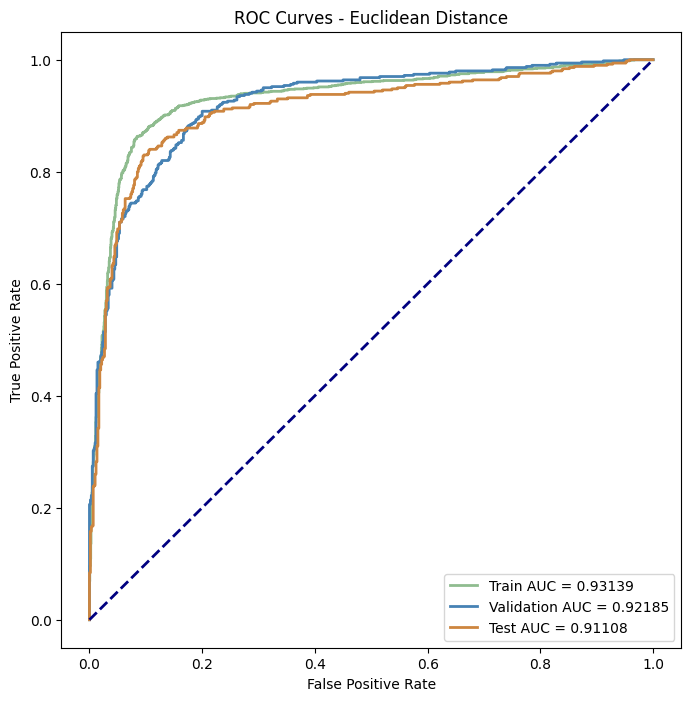

In [25]:
fpr_train, tpr_train, thresholds_train = roc_curve(train_labels, train_predictions, drop_intermediate=False)
roc_auc_train = auc(fpr_train, tpr_train)
fpr_validation, tpr_validation, thresholds_validation = roc_curve(validation_labels, validation_predictions, drop_intermediate=False)
roc_auc_validation = auc(fpr_validation, tpr_validation)
fpr_test, tpr_test, thresholds_test = roc_curve(test_labels, test_predictions, drop_intermediate=False)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curve
plt.figure(figsize=(8, 8))

plt.plot(fpr_train, tpr_train, color='darkseagreen', lw=2, label=f'Train AUC = {roc_auc_train:.5f}')
plt.plot(fpr_validation, tpr_validation, color='steelblue', lw=2, label=f'Validation AUC = {roc_auc_validation:.5f}')
plt.plot(fpr_test, tpr_test, color='peru', lw=2, label=f'Test AUC = {roc_auc_test:.5f}')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Euclidean Distance')
plt.legend(loc='lower right')
plt.show()

In [26]:
print(f'train auc : {roc_auc_train}')
print(f'validation auc : {roc_auc_validation}')
print(f'test auc : {roc_auc_test}')

train auc : 0.9313876984126983
validation auc : 0.9218500000000001
test auc : 0.9110766666666668


In [27]:
def find_tpr_at_fpr(fpr, tpr, target_fpr):
    return np.interp(target_fpr, fpr, tpr)

target_fprs = [0.1, 0.01, 0.001]

tpr_at_target_fpr_train = [find_tpr_at_fpr(fpr_train, tpr_train, fpr) for fpr in target_fprs]
tpr_at_target_fpr_test = [find_tpr_at_fpr(fpr_test, tpr_test, fpr) for fpr in target_fprs]
tpr_at_target_fpr_val = [find_tpr_at_fpr(fpr_validation, tpr_validation, fpr) for fpr in target_fprs]

print("Train")
for tpr, fpr in zip(tpr_at_target_fpr_train, target_fprs):
    print(f'TPR at FPR {fpr:.3f}: {tpr:.3f}')
print(f'             AUC: {roc_auc_train}')

print("Validation")
for tpr, fpr in zip(tpr_at_target_fpr_val, target_fprs):
    print(f'TPR at FPR {fpr:.3f}: {tpr:.3f}')
print(f'             AUC: {roc_auc_validation}')

print("Test")
for tpr, fpr in zip(tpr_at_target_fpr_test, target_fprs):
    print(f'TPR at FPR {fpr:.3f}: {tpr:.3f}')
print(f'             AUC: {roc_auc_test}')

Train
TPR at FPR 0.100: 0.873
TPR at FPR 0.010: 0.312
TPR at FPR 0.001: 0.095
             AUC: 0.9313876984126983
Validation
TPR at FPR 0.100: 0.768
TPR at FPR 0.010: 0.316
TPR at FPR 0.001: 0.206
             AUC: 0.9218500000000001
Test
TPR at FPR 0.100: 0.830
TPR at FPR 0.010: 0.260
TPR at FPR 0.001: 0.084
             AUC: 0.9110766666666668


### Extract Feature

In [42]:
def extract_features(input_data):
    # Get embeddings up to the penultimate layer
    feature_extractor = models.Sequential(embedding_model.layers[:-1])
    return feature_extractor(input_data)

# Display the summary of the feature extraction model
feature_extractor_model = models.Sequential(embedding_model.layers[:-1])
feature_extractor_model.build(input_shape=(None,) + input_shape)
feature_extractor_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
Total params: 426880 (1.63 MB)
Trainable params: 426880 (1.63 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [43]:
train_features_extracted = extract_features(train_features)
validation_features_extracted = extract_features(validation_features)
test_features_extracted = extract_features(test_features)

In [44]:
triplet_loss_train_features_path =  "../feature/BENGALI-feature/train_features_triplet_loss.npy"
triplet_loss_validation_features_path =  "../feature/BENGALI-feature/validation_features_triplet_loss.npy"
triplet_loss_test_features_path =  "../feature/BENGALI-feature/test_features_triplet_loss.npy"

In [45]:
np.save(triplet_loss_train_features_path, train_features_extracted)
np.save(triplet_loss_test_features_path, test_features_extracted)
np.save(triplet_loss_validation_features_path, validation_features_extracted)